In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy.random as nr

import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn import preprocessing
import sklearn.metrics as sklm

%matplotlib inline

In [2]:
train_data = pd.read_csv('preped_data_filled_missing_with_mean.csv')
labels = np.array(train_data['accepted'])

In [21]:
feature_cols = ['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'loan_amount', 'preapproval', 
                'msa_md', 'state_code', 'county_code', 'applicant_income',
                'tract_to_msa_md_income_pct', 'number_of_owner-occupied_units', 'lender']

print(len(feature_cols))

features = np.array(train_data[feature_cols])
print(features.shape)

13
(500000, 13)


In [22]:
nr.seed(9988)
indx = range(features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

In [23]:
scaler = preprocessing.StandardScaler().fit(X_train[:,12:])
X_train[:,12:] = scaler.transform(X_train[:,12:])
X_test[:,12:] = scaler.transform(X_test[:,12:])

In [24]:
logistic_mod = linear_model.LogisticRegression()
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-0.9204919]
[[ 4.66702701e-02 -1.08938491e+00 -4.61115257e-01  1.97933758e-01
   5.12639513e-04  4.85219218e-01  3.00551615e-05  5.14149052e-03
  -7.28335006e-05  8.16311431e-04  1.11705377e-02  3.63236583e-05
   2.62788462e-02]]


In [26]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.42377222 0.57622778]
 [0.56256572 0.43743428]
 [0.53374754 0.46625246]
 [0.32656981 0.67343019]
 [0.5470909  0.4529091 ]
 [0.32049325 0.67950675]
 [0.83363134 0.16636866]
 [0.54240048 0.45759952]
 [0.54455194 0.45544806]
 [0.5288481  0.4711519 ]
 [0.50933489 0.49066511]
 [0.59233869 0.40766131]
 [0.29944627 0.70055373]
 [0.5196751  0.4803249 ]
 [0.28838643 0.71161357]]


In [27]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[1 0 0 1 0 1 0 0 0 0 0 0 1 0 1]
[0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0.]


In [28]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive        99                45
Actual negative        74                82

Accuracy  0.60
 
           Positive      Negative
Num case      144           156
Precision    0.57          0.65
Recall       0.69          0.53
F1           0.62          0.58


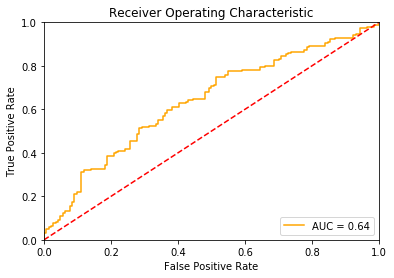

In [29]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)